In [1]:
%pylab inline

import numpy as np
import matplotlib.pyplot as plt

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Populating the interactive namespace from numpy and matplotlib


In [2]:
from mpl_toolkits.mplot3d import Axes3D

In [3]:
pyplot.rcParams.update({
    'figure.figsize': (8, 6),    # figure size in inches
    'text.usetex': True,
#     "font.family": 'serif',
#     "font.serif": ['Computer Modern'],
    'font.size': 14,
    #'axes.titlesize': 20,
    'axes.labelsize': 20,
    'axes.linewidth': 2,
    'xtick.labelsize': 20,
    'ytick.labelsize': 20,
    'legend.fontsize': 14,
    'xtick.major.size': 8,
    'xtick.minor.size': 4, 
    'xtick.major.width': 2,
    'xtick.minor.width': 2,
    'xtick.direction': 'out',
    'ytick.major.size': 8,
    'ytick.minor.size': 4, 
    'ytick.major.width': 2,
    'ytick.minor.width': 2,
    'ytick.direction': 'out',  
    #'axes.prop_cycle'    : cycler('color', 'bgrcmyk'),
    })

# Latin Hypercube

In [4]:
def latin_hypercube(Ndata, limits):
    """Select parameters using the Latin Hypercube method.
    
    Parameters
    ----------
    Ndata : int
        Number of points to select.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    """
    Nparams = len(limits)
    
    # Find indices of grid points
    point_ind_list = []
    allowed_indices = np.array([[n for n in range(Ndata)] for i in range(Nparams)])
    for n in range(Ndata):
        js = np.random.randint(Ndata-n, size=Nparams)
        point_ind = [allowed_indices[i, js[i]] for i in range(Nparams)]
        point_ind_list.append(point_ind)
        allowed_indices = np.array([np.delete(allowed_indices[i], js[i]) for i in range(Nparams)])
    
    point_ind_array = np.array(point_ind_list)
    
    # Get grid points
    grids = []
    for i in range(Nparams):
        grids.append(np.linspace(limits[i, 0], limits[i, 1], Ndata))
    
    grids_array = np.array(grids)
    
    # Get chosen points on the grid
    points = np.array([[grids_array[i, point_ind_array[n, i]] for i in range(Nparams)] for n in range(Ndata)])
    
    return points

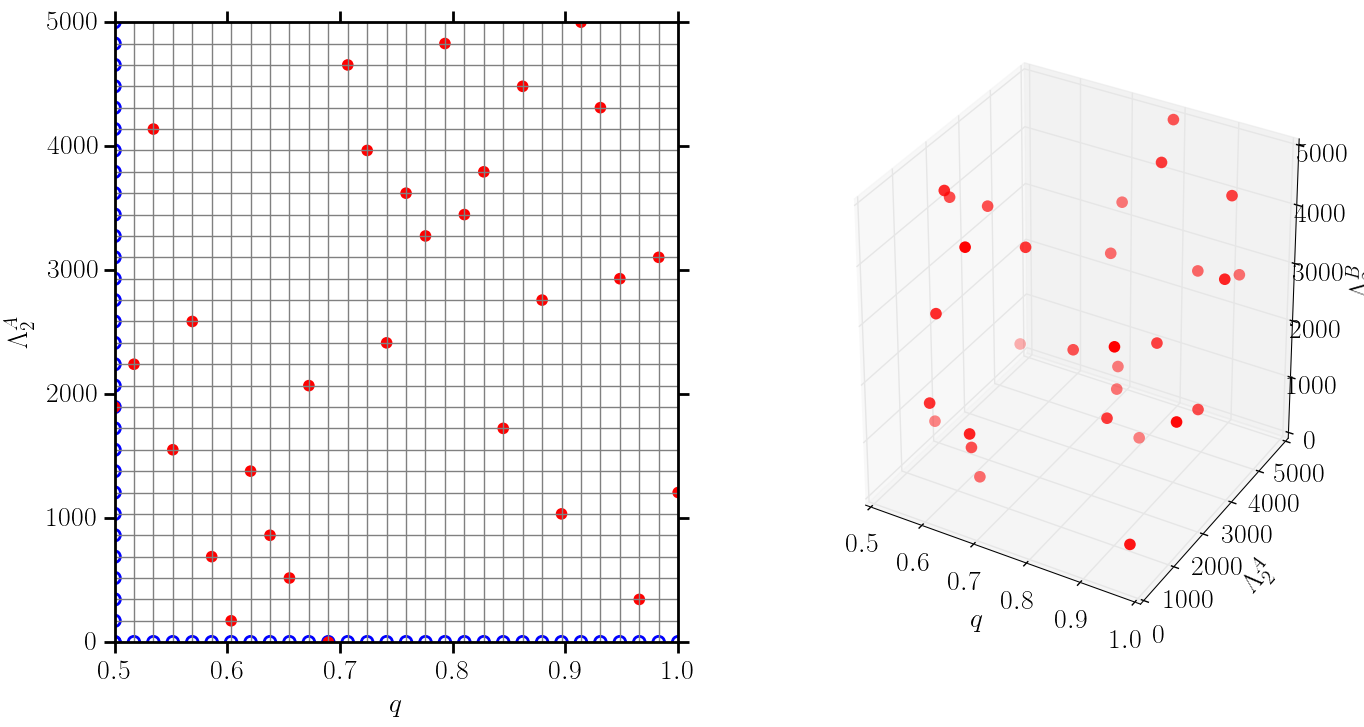

In [5]:
# Make 3d latin hypercube points
Ndata = 30
limits = np.array([[0.5, 1.0], [0, 5000], [0, 5000]])
points = latin_hypercube(Ndata, limits)


# ******* plot data *******
fig = plt.figure(figsize=(16, 8))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(121)

for p in points[:, 0]:
    axes.axvline(p, c='grey', lw=1)

for p in points[:, 1]:
    axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$q$')
axes.set_ylabel(r'$\Lambda_2^A$')


# ****** Full 3d data ******
axes = fig.add_subplot(122, projection='3d')

x, y, z = points[:, 0], points[:, 1], points[:, 2]
axes.scatter(x, y, z, c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_zlim(limits[2])
axes.set_xlabel(r'$q$', labelpad=10)
axes.set_ylabel(r'$\Lambda_2^A$', labelpad=15)
axes.set_zlabel(r'$\Lambda_2^B$', labelpad=18)

# Gaussian process class

In [6]:
class GaussianProcess(object):
    """
    """
    def __init__(self, params, y, cov, *covargs):
        """Gaussian Process for n dimensional set of data.
        
        Parameters
        ----------
        params : array of shape (nparams, ndim).
            Parameters of sampled data.
        y : array of shape nparams.
            Data at each of the sampled parameters.
        cov : func(p1, p2, *covargs)
            Covariance function.
        covargs : args
            Arguments for the covariance function.
        """
        self.cov = cov
        self.covargs = covargs
        self.params = params
        self.y = y
        self.nparams, self.ndim = params.shape
        
        # Evaluate K and K^{-1}
        self.K = np.array([[self.cov(p1, p2, *self.covargs) for p2 in self.params] for p1 in self.params])
        self.Kinv = np.linalg.inv(self.K)

    # Break this up into 2 functions for mean and variance. You don't always need to calculate the variance.
    def __call__(self, ps):
        """Evaluate the function and estimate the error at the points ps.
        
        Parameters
        ----------
        ps : list of length n arrays.
            Points where you want to evaluate the function.
        
        Returns
        -------
        ys : array of length n
            Interpolated value at each point ps.
        sqrt(ysvar) : array of length n
            Estimate of the interpolation error at each point ps.
        """
        # Evaluate K_*, K_**
        Ks = np.array([self.cov(ps, p1, *self.covargs) for p1 in self.params])
        Kss = self.cov(ps, ps, *self.covargs)
        
        # Evaluate y_*
        # !!!!!!!!! Kinv_y can be stored as an attribute. It only needs to be calculated once. !!!!!!!!!
        # Ks and Kinv_y are both vectors of length nparams.
        Kinv_y = np.dot(self.Kinv, self.y)
        ys = np.dot(Ks, Kinv_y)
        
        # Evaluate variance at y_*
        ysvar = Kss - np.dot(Ks, np.dot(self.Kinv, Ks.T) )
        
        return ys, np.sqrt(ysvar)
    
    def lnlike(self):
        """Log likelihood of the Gaussian Process given the hyperparameters covargs.
        Expression is the sum of 3 terms: data, complexity penalty, normalization
        """
        Kdet = np.linalg.det(self.K)
        return -0.5*np.dot(self.y.T, np.dot(self.Kinv, self.y)) - 0.5*np.log(Kdet) - 0.5*self.nparams*np.log(2.0*np.pi)

In [7]:
# Class for set of GaussianProcess with common covariance function and data
# Should this be a class that inherits the methods of GaussianProcess? Is that how things work?
class GaussianProcessSet(object):
    def __init__(self, params, y, cov):
        """Gaussian Process for n dimensional set of data.
        
        Parameters
        ----------
        params : array of shape (nparams, ndim).
            Parameters of sampled data.
        y : array of shape nparams.
            Data at each of the sampled parameters.
        cov : func(p1, p2, *covargs)
            Covariance function.
        covargs : args
            Arguments for the covariance function.
        """
        self.cov = cov
        self.params = params
        self.y = y
        
    def ln_like_of_log_hyperparams(log_sigma_f, log_sigma_n, log_l0, log_l1):
        """Natural log likelihood as a function of the base 10 log of the hyperparameters.
        """
        gp = GaussianProcess(params, z, squared_exponential_covariance, 
                             10.0**log_sigma_f, 10.0**log_sigma_n, 10.0**log_l0, 10.0**log_l1)
        return gp.lnlike()

    def neg_ln_like(theta):
        return -ln_like_of_log_hyperparams(theta[0], theta[1], theta[2], theta[3])

In [ ]:
# def lnlike(params, y, cov, *covargs):
#     Nparams = len(params[0])
#     # Evaluate K and K^{-1}
#     K = np.array([[cov(p1, p2, *covargs) for p2 in params] for p1 in params])
#     Kinv = np.linalg.inv(K)
#     Kdet = np.linalg.det(K)
#     return -0.5*np.dot(y.T, np.dot(Kinv, y)) - 0.5*np.log(Kdet) - 0.5*Nparams*np.log(2.0*np.pi)
    
# def lnprior(covparams):
#     sigma_f = covparams[0]
#     sigma_n = covparams[1]
#     ls0 = covparams[2]
#     ls1 = covparams[3]
    
#     if (0.1 < sigma_f < 50.0 and  0.001 < sigma_n < 0.02 and 
#         0.2 < ls0 < 10.0 and 0.2 < ls1 < 50.0):
#         return 0.0
#     return -np.inf

# def lnpost(covparams, params, y, cov):
#     lp = lnprior(covparams)
#     covargs = (covparams[0], covparams[1], np.array([covparams[2], covparams[3]]))
#     return lp + lnlike(params, y, cov, *covargs) if np.isfinite(lp) else -np.inf

# Covariance functions

In [8]:
def squared_exponential_covariance(point1, point2, sigma_f, sigma_n, *length_scales):
    """Squared exponential covariance function for n-dimensional data.
    
    Parameters
    ----------
    p1 : array like, length ndim
    p2 : array like, length ndim
    sigma_f : float
        Approximately the range (ymax-ymin) of values that the data takes.
        sigma_f^2 called the signal variance.
    sigma_n : float
        Noise term. The uncertainty in the y values of the data.
    ls : floats. ndim additional parameters.
        The length scales for the variation in each dimension.
        
    Returns
    -------
    covariance : float
    """
    # convert data to numpy arrays. (It started as either scalar or list like).
    p1 = np.array([point1]).flatten()
    p2 = np.array([point2]).flatten()
    ls = np.array([length_scales]).flatten()
    # !!!!!!!! assert that p1, p2, ls have same shape !!!!!!!!!! #
    
    # Dimensionality of each data point
    ndim = len(ls)
    
    # Noise nugget for diagonal elements
    if np.array_equal(p1, p2):
        nugget = sigma_n**2
    else:
        nugget = 0.0
    
    # Calculate the covariance
    squares = np.array([-(p1[i]-p2[i])**2 / (2*ls[i]**2) for i in range(ndim)])
    lnexp = np.sum(squares)
    return sigma_f**2 * np.exp(lnexp) + nugget

In [73]:
# def cov(x1, x2, sigma_f, sigma_n, l):
#     """
#     """
#     if x1==x2:
#         nugget = sigma_n**2
#     else:
#         nugget = 0.0
        
#     return sigma_f**2 * np.exp( -(x1-x2)**2 / (2*l**2) ) + nugget

In [74]:
# def covnd(p1, p2, sigma_f, sigma_n, ls):
#     """
#     """
#     Nparams = len(ls)
    
#     if np.array_equal(p1, p2):
#         nugget = sigma_n**2
#     else:
#         nugget = 0.0
    
#     squares = np.array([-(p1[i]-p2[i])**2 / (2*ls[i]**2) for i in range(Nparams)])
#     lnexp = np.sum(squares)
#     return sigma_f**2 * np.exp(lnexp) + nugget

In [75]:
p1 = 2.
p2 = 5.
print squared_exponential_covariance(p1, p2, 5, 0.1, 3.2)
print cov(p1, p2, 5, 0.1, 3.2)

16.1097181206
16.1097181206


In [83]:
# p1 = np.array([[2, 5], [7.5, 3.2], [3.4, 8.4]])
# p2 = np.array([[7.2, 8.9], [3.8, 7.2], [9.6, 8.3]])
p1 = np.array([2, 5])
p2 = np.array([7.2, 8.9])
print squared_exponential_covariance(p1, p2, 5, 0.1, 3.2, 7.5)
print covnd(p1, p2, 5, 0.1, [3.2, 7.5])

5.83201942154
5.83201942154


# Testing

# 1D

In [13]:
#x = np.array([-6.0, -5.0, -3.0, 0.0, 1.2, 1.5, 1.9, 3.0, 4.0, 5.2, 6, 7])
x = np.linspace(-6.0, 7.0, 50.0)

def func(x):
    return np.sin(x*(1.0+0.05*x)) + 0.5*x + 10

sigma = 0.000001
y = func(x) + np.random.normal(0.0, sigma, x.shape)

params = np.array([x]).T
sigma_f = 10
sigma_n = 0.1
l = 2
gp = GaussianProcess(params, y, squared_exponential_covariance, sigma_f, sigma_n, l)
gp.lnlike()

17.027078498382629

(5.9589242746631381, 15.814484779937501)

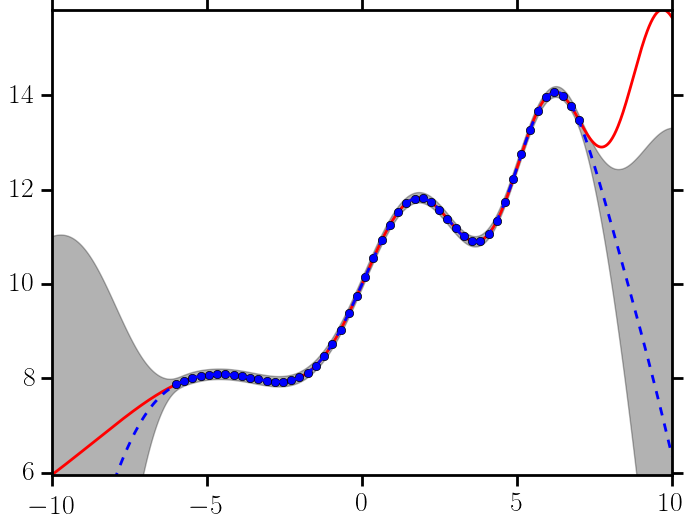

In [11]:
xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys = np.array([gp(p)[0] for p in xs])
ysvar = np.array([gp(p)[1] for p in xs])

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ysvar, ys+ysvar, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

In [388]:
def ln_like_of_log_hyperparams(log_sigma_f, log_sigma_n, log_l):
    """Natural log likelihood as a function of the base 10 log of the hyperparameters.
    """
    gp = GaussianProcess(params, y, squared_exponential_covariance, 10.0**log_sigma_f, 10.0**log_sigma_n, 10.0**log_l)
    return gp.lnlike()

def neg_ln_like(theta):
    return -ln_like_of_log_hyperparams(theta[0], theta[1], theta[2])

In [389]:
log_sigma_n = np.log10(0.05)
xgrid = np.arange(0, 3, 0.1)
ygrid = np.arange(-2, 2, 0.1)
X, Y = np.meshgrid(xgrid, ygrid)
Z = np.array([[ln_like_of_log_hyperparams(X[i, j], log_sigma_n, Y[i, j]) for j in range(len(X[0]))] for i in range(len(X))])

In [390]:
indices_max = unravel_index(Z.argmax(), Z.shape)
indices_max

(23, 8)

In [391]:
indices_max = unravel_index(Z.argmax(), Z.shape)
#Z[indices_max], xgrid[indices_max[0]], ygrid[indices_max[1]]
ymax = 10**ygrid[indices_max[0]]
xmax = 10**xgrid[indices_max[1]]
xmax, ymax

(6.3095734448019334, 1.9952623149688891)

In [392]:
import scipy.optimize as optimize
x0 = [np.log10(xmax), np.log10(0.05), np.log10(ymax)]
res = optimize.minimize(neg_ln_like, x0)

In [393]:
x0, res.x, neg_ln_like(res.x), 10**res.x

([0.80000000000000004, -1.3010299956639813, 0.30000000000000204],
 array([ 0.87563721, -0.98325396,  0.42237858]),
 -4.7582634161854926,
 array([ 7.5099528 ,  0.10393122,  2.64471321]))

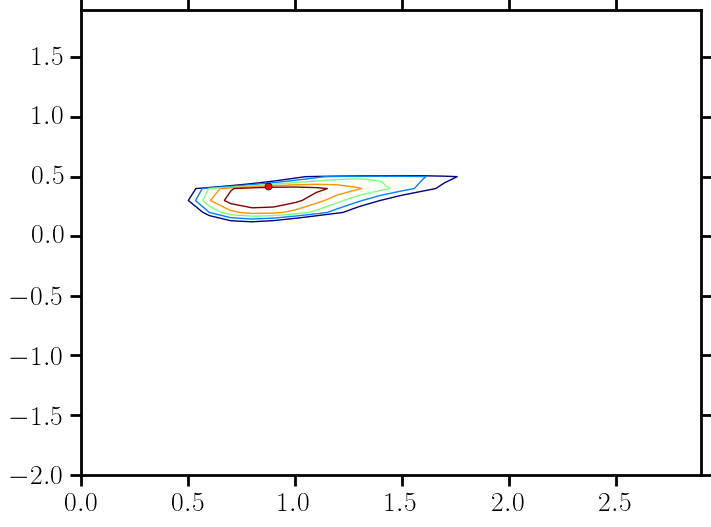

In [394]:
levels = Z.max() + np.arange(-10, 0, 2)

fig, axes = plt.subplots(figsize=(8, 6))
axes.contour(X, Y, Z, levels)
axes.plot(res.x[0], res.x[2], 'ro', markersize=5)

[ 7.5099528   0.10393122  2.64471321]


(5.9589242746631381, 15.814484779937501)

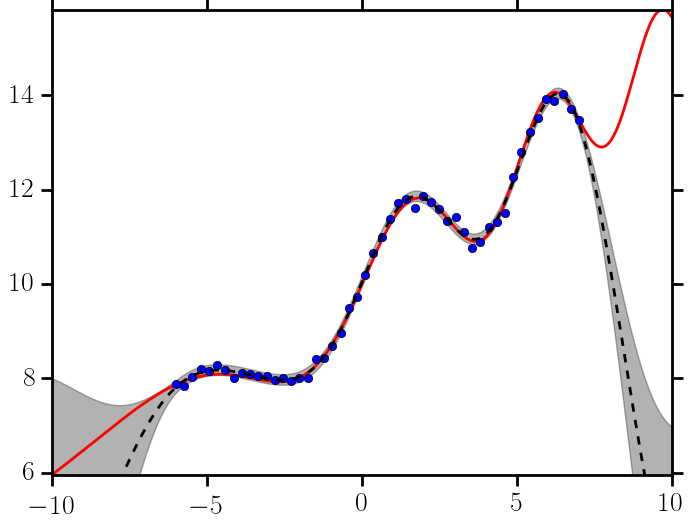

In [395]:
print 10**res.x
sigma_f, sigma_n, l = 10**res.x
gp = GaussianProcess(params, y, squared_exponential_covariance, sigma_f, sigma_n, l)

xall = np.linspace(-10, 10, 1000)
yall = func(xall)

xs = np.linspace(-10, 10, 1000)
ys = np.array([gp(p)[0] for p in xs])
ysvar = np.array([gp(p)[1] for p in xs])

fig, axes = plt.subplots(figsize=(8, 6))
axes.plot(xall, yall, c='r', lw=2)
axes.plot(x, y, 'bo')
axes.plot(xs, ys, c='k', ls='--', lw=2)
axes.fill_between(xs, ys-ysvar, ys+ysvar, color='k', alpha=0.3)
axes.set_ylim(np.min(yall), np.max(yall))

# 2D

In [449]:
def uniform_random_samples(ndata, limits):
    """Select parameters in a hypercube sampled uniformly in the range limits.
    
    Parameters
    ----------
    Ndata : int
        Number of points to select.
    limits : np.array([[x1_min, x1_max], [x2_min, x2_max], [x3_min, x3_max], ...])
        Boundaries of the hypercube.
    """
    ndim = len(limits)
    
    param_columns = []
    for i in range(ndim):
        xi_min, xi_max = limits[i]
        xis = np.random.uniform(low=xi_min, high=xi_max, size=ndata)
        param_columns.append(xis)
    
    return np.array(param_columns).T

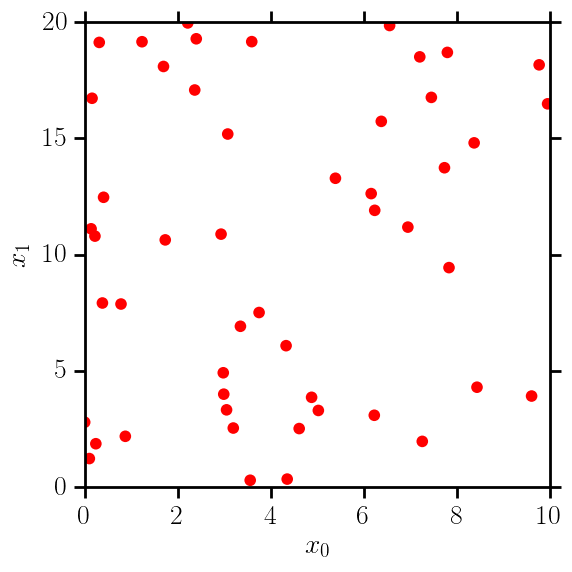

In [497]:
# Make 3d latin hypercube points
Ndata = 50
limits = np.array([[0, 10], [0, 20]])
#points = latin_hypercube(Ndata, limits)
points = uniform_random_samples(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

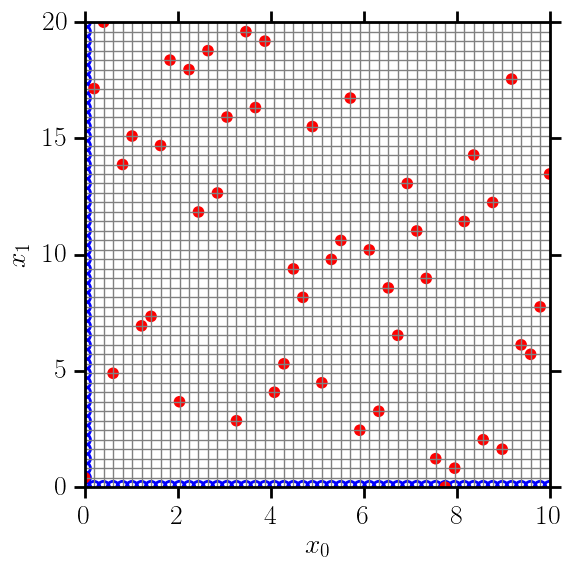

In [503]:
# Make 3d latin hypercube points
Ndata = 50
limits = np.array([[0, 10], [0, 20]])
points = latin_hypercube(Ndata, limits)

# ******* plot data *******
fig = plt.figure(figsize=(6, 6))

# ****** 1d and 2d projections ******
axes = fig.add_subplot(111)

for p in points[:, 0]:
    axes.axvline(p, c='grey', lw=1)

for p in points[:, 1]:
    axes.axhline(p, c='grey', lw=1)
    
axes.scatter(min(points[:, 0])+0.0*points[:, 0], points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)
axes.scatter(points[:, 0], min(points[:, 1])+0.0*points[:, 1], marker='o', s=70, c='none', edgecolors='b', linewidth=2)

axes.scatter(points[:, 0], points[:, 1], c='r', edgecolor='none', marker='o', s=70)

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])
axes.set_xlabel(r'$x_0$')
axes.set_ylabel(r'$x_1$')

In [504]:
params = points

# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

z = np.array([func(params[i, 0], params[i, 1]) for i in range(len(params))])

# Construct Gaussian process
sigma_f = 2.0
sigma_n = 0.01
ls0 = 3
ls1 = 10
gp = GaussianProcess(params, z, squared_exponential_covariance, sigma_f, sigma_n, ls0, ls1)
gp.lnlike()

30.842944479992305

In [505]:
def ln_like_of_log_hyperparams(log_sigma_f, log_sigma_n, log_l0, log_l1):
    """Natural log likelihood as a function of the base 10 log of the hyperparameters.
    """
    gp = GaussianProcess(params, z, squared_exponential_covariance, 
                         10.0**log_sigma_f, 10.0**log_sigma_n, 10.0**log_l0, 10.0**log_l1)
    return gp.lnlike()

def neg_ln_like(theta):
    return -ln_like_of_log_hyperparams(theta[0], theta[1], theta[2], theta[3])

In [506]:
import scipy.optimize as optimize
x0 = [np.log10(10.0), np.log10(0.01), np.log10(3), np.log10(3)]
res = optimize.minimize(neg_ln_like, x0)
print 10**res.x

[  2.05024882e+01   1.41104340e-04   4.00567873e+00   3.68367187e+01]


In [507]:
sigma_f, sigma_n, l0, l1 = 10**res.x
gp = GaussianProcess(params, z, squared_exponential_covariance, sigma_f, sigma_n, l0, l1)

/Users/lackey/virtenvs/aei/lib/python2.7/site-packages/ipykernel/__main__.py:55: RuntimeWarning: invalid value encountered in sqrt


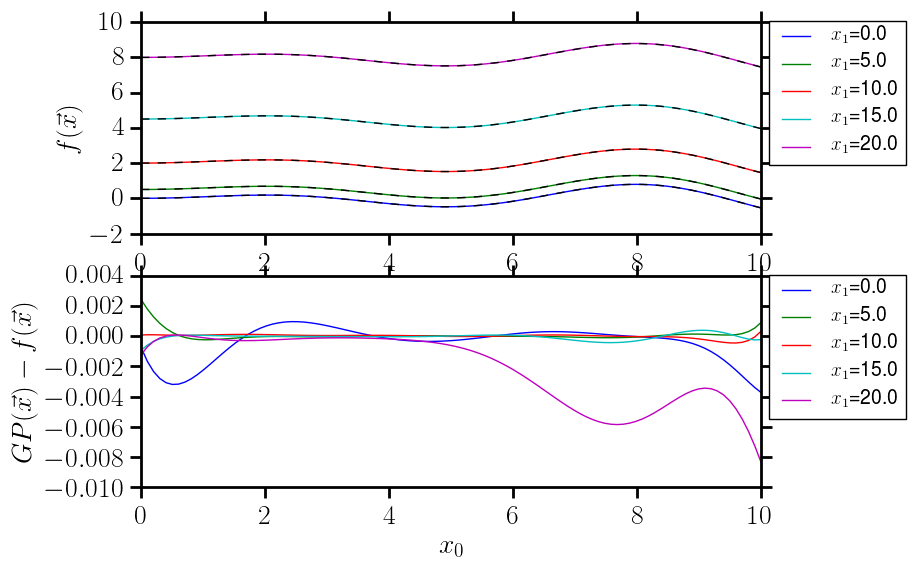

In [508]:
fig, ax = plt.subplots(2)
for y in np.linspace(0, 20, 5):
    xs = np.linspace(0, 10, 100)
    ps = np.array([[x, y] for x in xs])
    
    true = np.array([func(p[0], p[1]) for p in ps])
    interp = np.array([gp(p)[0] for p in ps])
    
    ax[0].plot(xs, true, label=r'$x_1$='+str(y))
    ax[0].plot(xs, interp, c='k', ls='--')
    
    ax[1].plot(xs, (interp-true), label=r'$x_1$='+str(y))

ax[0].set_ylabel(r'$f(\vec x)$')
ax[1].set_ylabel(r'$GP(\vec x)-f(\vec x)$')
ax[1].set_xlabel(r'$x_0$')
ax[0].legend(bbox_to_anchor=(1.25, 1.05))
ax[1].legend(bbox_to_anchor=(1.25, 1.05))

# Old Junk

(-10, 10)

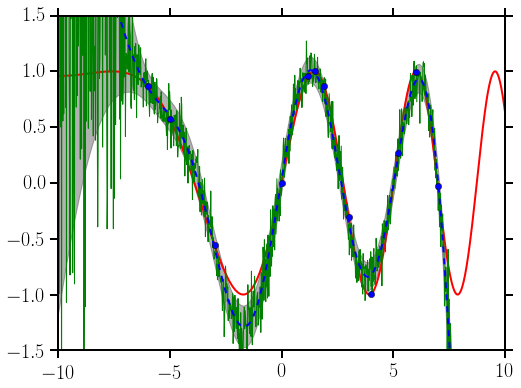

In [11]:
xs = np.linspace(-10, 10, 1000)
ys = np.array([gp.evaluate(p)[0] for p in xs])
ysvar = np.array([gp.evaluate(p)[1] for p in xs])
yssample = np.array([gp.sample_gaussian_process(p) for p in xs])

fig, axes = plt.subplots()
axes.plot(xall, yall, c='r', lw=2)
axes.plot(xs, yssample)

axes.plot(x, y, 'bo')

axes.plot(xs, ys, c='b', ls='--', lw=2)
axes.fill_between(xs, ys-ysvar, ys+ysvar, color='k', alpha=0.3)
axes.set_ylim(-1.5, 1.5)
axes.set_xlim(-10, 10)

## 2D

In [74]:
# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2
x = np.random.rand(50)*20.0-10.0
y  = np.random.rand(50)*20.0-10.0
params = np.array([x, y]).T
z = func(params[:, 0], params[:, 1])

# Construct Gaussian process
sigma_f = 2.0
sigma_n = 0.01
ls = np.array([3.0, 10])
gp = GaussianProcess(params, z, covnd, sigma_f, sigma_n, ls)

# Evaluate exact model on grid
xgrid = np.arange(-10, 10, 0.2)
ygrid = np.arange(-10, 10, 0.2)
zgrid = np.array([[func(xp, yp) for yp in ygrid] for xp in xgrid])

# Evaluate Gaussian process on grid
zgpgrid = np.array([[gp.evaluate(np.array([xp, yp]))[0] for yp in ygrid] for xp in xgrid])
zgpsiggrid = np.array([[gp.evaluate(np.array([xp, yp]))[1] for yp in ygrid] for xp in xgrid])

(-10, 10)

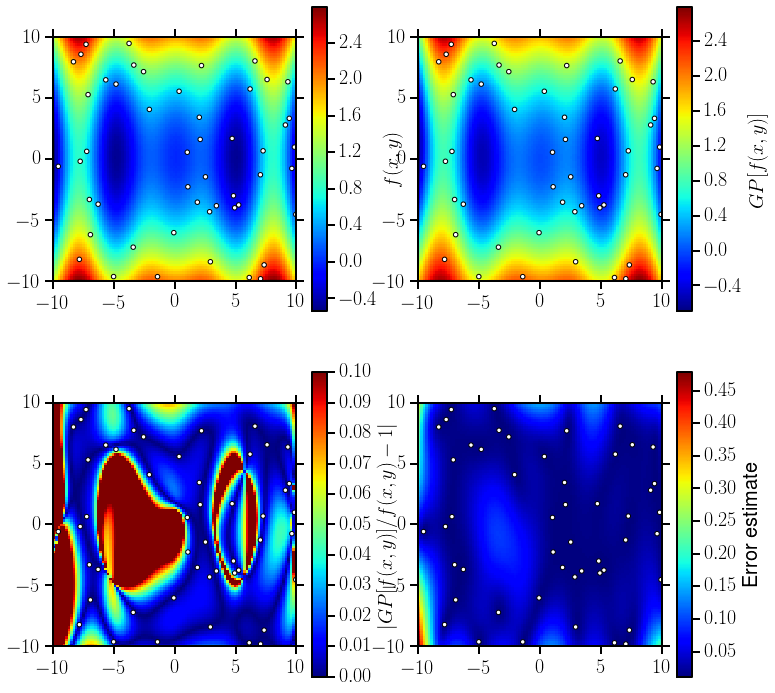

In [75]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = ax[0, 0]
extent = [-10, 10, -10, 10]
#im = axes.imshow(zgrid.T, cmap=plt.get_cmap('hot'), interpolation='bilinear', origin='lower')
im = axes.imshow(zgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$f(x, y)$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[0, 1]
im = axes.imshow(zgpgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$GP[f(x, y)]$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 0]
im = axes.imshow(np.abs(zgpgrid.T/zgrid.T-1.0), interpolation='nearest', origin='lower', extent=extent,
                norm=Normalize(vmin=0, vmax=0.1))
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$|GP[f(x, y)]/f(x, y)-1|$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 1]
im = axes.imshow(zgpsiggrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'Error estimate')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

In [96]:
def lnlike(params, y, cov, *covargs):
    Nparams = len(params[0])
    # Evaluate K and K^{-1}
    K = np.array([[cov(p1, p2, *covargs) for p2 in params] for p1 in params])
    Kinv = np.linalg.inv(K)
    Kdet = np.linalg.det(K)
    return -0.5*np.dot(y.T, np.dot(Kinv, y)) - 0.5*np.log(Kdet) - 0.5*Nparams*np.log(2.0*np.pi)
    
def lnprior(covparams):
    sigma_f = covparams[0]
    sigma_n = covparams[1]
    ls0 = covparams[2]
    ls1 = covparams[3]
    
    if (0.1 < sigma_f < 50.0 and  0.001 < sigma_n < 0.02 and 
        0.2 < ls0 < 10.0 and 0.2 < ls1 < 50.0):
        return 0.0
    return -np.inf

def lnpost(covparams, params, y, cov):
    lp = lnprior(covparams)
    covargs = (covparams[0], covparams[1], np.array([covparams[2], covparams[3]]))
    return lp + lnlike(params, y, cov, *covargs) if np.isfinite(lp) else -np.inf

In [97]:
lnpost(np.array([3.0, 0.01, 6.0, 2.0]), params, z, covnd)

-32.71067360160054

In [78]:
ls0s = np.arange(0.0, 11.0, 0.5)
posts = np.array([lnpost(np.array([3.0, 0.01, ls0, 2.0]), params, z, covnd) for ls0 in ls0s])

In [79]:
posts

array([         -inf,  -54.9280928 ,  -48.17104235,  -41.89622787,
        -36.39683198,  -31.64521013,  -27.81693811,  -25.08990535,
        -23.57029785,  -23.26183793,  -24.33554072,  -27.27168964,
        -32.7106736 ,  -41.34476612,  -53.94408312,  -71.43853344,
        -95.00520992, -126.13064541, -166.62524103, -218.57727678,
                -inf,          -inf])

In [80]:
# def nll(covparams, params, y, cov):
#     # Update the kernel parameters and compute the likelihood.
#     ll = lnpost(covparams, params, y, cov)

#     # The scipy optimizer doesn't play well with infinities.
#     return -ll if np.isfinite(ll) else 1e25

def nll(covparams):
    # Update the kernel parameters and compute the likelihood.
    ll = lnpost(covparams, params, z, covnd)

    # The scipy optimizer doesn't play well with infinities.
    return -ll if np.isfinite(ll) else 1e25

In [81]:
nll(np.array([3.0, 0.01, 4.0, 4.0]))

33.738167965150836

In [82]:
import scipy.optimize

In [83]:
x0 = np.array([0.5, 0.01, 4.0, 4.0])
res = scipy.optimize.minimize(nll, x0)

In [84]:
res.x

array([ 0.5 ,  0.01,  4.  ,  4.  ])

In [109]:
# Construct Gaussian process
sigma_f = res.x[0]
sigma_n = res.x[1]
ls = np.array([res.x[2], res.x[3]])
gp = GaussianProcess(params, z, covnd, sigma_f, sigma_n, ls)

# Evaluate exact model on grid
xgrid = np.arange(-10, 10, 0.2)
ygrid = np.arange(-10, 10, 0.2)
zgrid = np.array([[func(xp, yp) for yp in ygrid] for xp in xgrid])

# Evaluate Gaussian process on grid
zgpgrid = np.array([[gp.evaluate(np.array([xp, yp]))[0] for yp in ygrid] for xp in xgrid])
zgpsiggrid = np.array([[gp.evaluate(np.array([xp, yp]))[1] for yp in ygrid] for xp in xgrid])

(-10, 10)

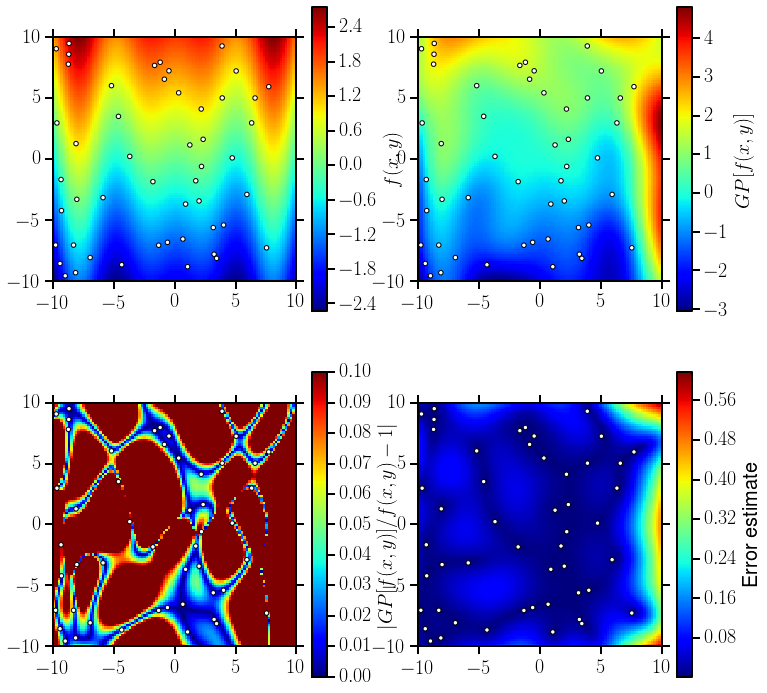

In [110]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = ax[0, 0]
extent = [-10, 10, -10, 10]
#im = axes.imshow(zgrid.T, cmap=plt.get_cmap('hot'), interpolation='bilinear', origin='lower')
im = axes.imshow(zgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$f(x, y)$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[0, 1]
im = axes.imshow(zgpgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$GP[f(x, y)]$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 0]
im = axes.imshow(np.abs(zgpgrid.T/zgrid.T-1.0), interpolation='nearest', origin='lower', extent=extent,
                norm=Normalize(vmin=0, vmax=0.1))
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$|GP[f(x, y)]/f(x, y)-1|$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 1]
im = axes.imshow(zgpsiggrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'Error estimate')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

In [85]:
def sample_walkers_uniformly_from_prior(nwalkers, limits, lnprior):
    """Place initial position of walkers uniformly in prior.
    This function removes points where lnprior is not 0.0.
    EMCEE walkers get lost if they start outside the prior region.
    """
    ndim = len(limits)
    pos = []
    for i in range(nwalkers):
        while True:
            p = limits[:, 0] + (limits[:, 1]-limits[:, 0])*np.random.rand(ndim)
            if lnprior(p) == 0.0:
                break
        pos+=[p]
        
    return pos

In [86]:
np.random.rand(1)

array([ 0.30435048])

In [104]:
nwalkers = 32
ndim = 4
limits = np.array([
            [0.1, 50.0], 
            [0.001, 0.02], 
            [0.2, 10.0], 
            [0.2, 50.0]
        ])
pos = sample_walkers_uniformly_from_prior(nwalkers, limits, lnprior)

In [105]:
import emcee
import time

In [106]:
# Initialize the EnsembleSampler object
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnpost, args=[params, z, covnd], threads=8)

t0 = time.clock()

# Run the production chain.
nsteps = 1000
sampler.run_mcmc(pos, nsteps, rstate0=np.random.get_state(), thin=1)

t1 = time.clock()
t1-t0

11.637225

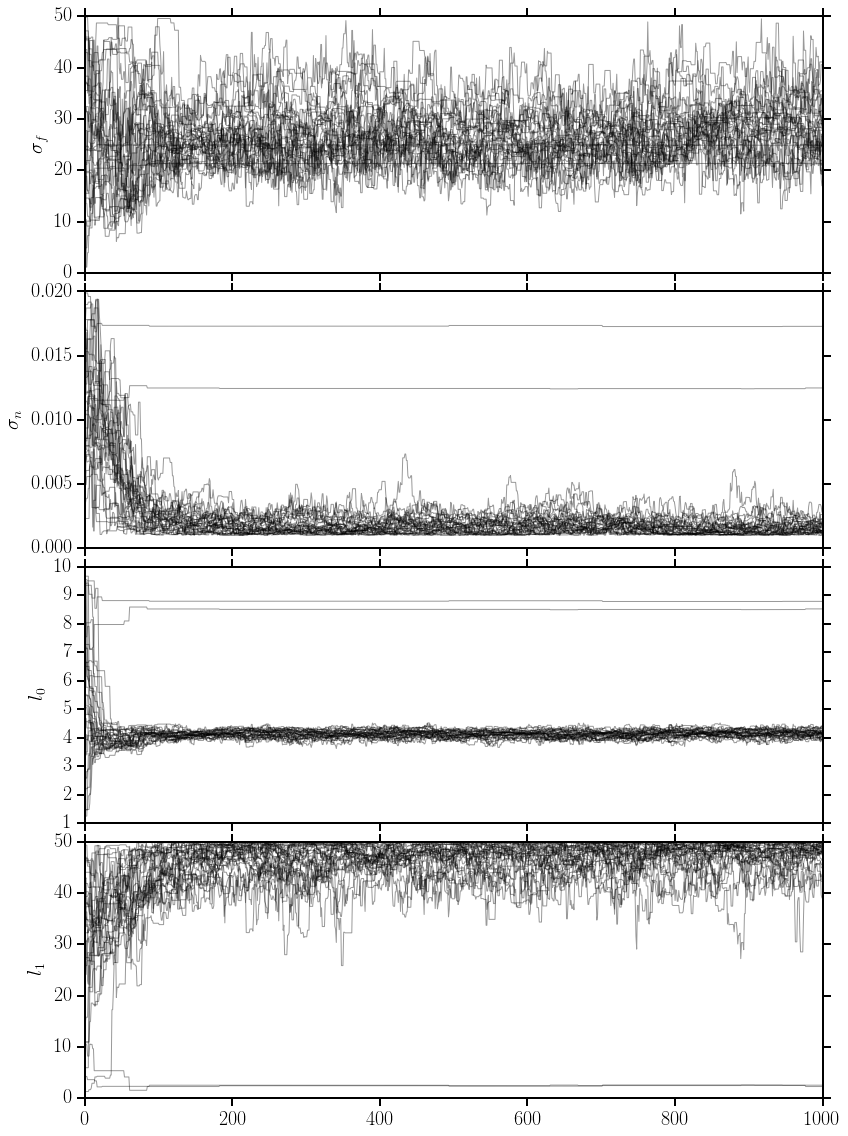

In [107]:
fig, axes = plt.subplots(ndim, 1, sharex=True, figsize=(12, 16))

labels = [r'$\sigma_f$', r'$\sigma_n$', r'$l_0$', r'$l_1$']

for i in range(ndim):
    axes[i].plot(sampler.chain[:, :, i].T, color="k", alpha=0.4)
    axes[i].set_ylabel(labels[i])

fig.tight_layout(h_pad=0.0)

In [108]:
import corner

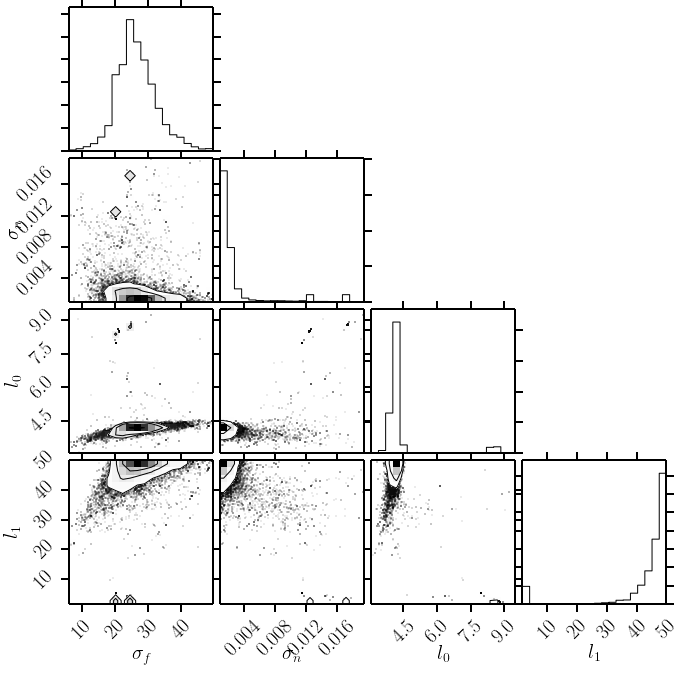

In [109]:
burnin = 10
samples = sampler.chain[:, burnin:, :].reshape((-1, ndim))
figure = corner.corner(samples, labels=labels)

In [110]:
#lnprobflat = sampler.lnprobability[temp_i].reshape(-1)
lnprobflat = sampler.lnprobability[:, burnin:].reshape(-1)
imax = np.argmax(lnprobflat)
params_max = samples.reshape(-1, ndim)[imax]

print imax, lnprobflat[imax]
print params_max

3468 81.2109438376
[  3.16329921e+01   1.00101742e-03   4.20408476e+00   4.97033266e+01]


In [111]:
# Construct Gaussian process
sigma_f = params_max[0]
sigma_n = params_max[1]
ls = np.array([params_max[2], params_max[3]])
#ls = np.array([params_max[2], 10.0])
gp = GaussianProcess(params, z, covnd, sigma_f, sigma_n, ls)

# Evaluate exact model on grid
xgrid = np.arange(-10, 10, 0.2)
ygrid = np.arange(-10, 10, 0.2)
zgrid = np.array([[func(xp, yp) for yp in ygrid] for xp in xgrid])

# Evaluate Gaussian process on grid
zgpgrid = np.array([[gp.evaluate(np.array([xp, yp]))[0] for yp in ygrid] for xp in xgrid])
zgpsiggrid = np.array([[gp.evaluate(np.array([xp, yp]))[1] for yp in ygrid] for xp in xgrid])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt


(-10, 10)

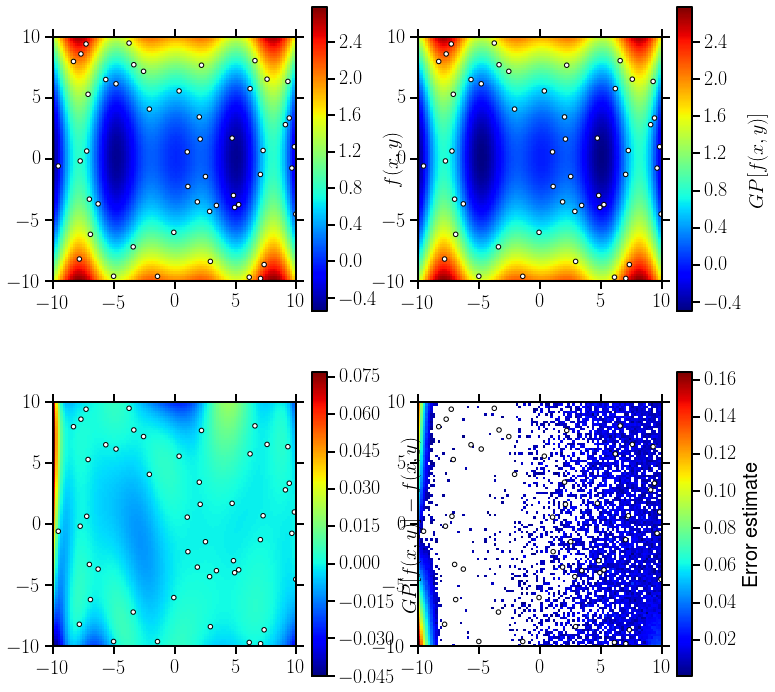

In [112]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = ax[0, 0]
extent = [-10, 10, -10, 10]
#im = axes.imshow(zgrid.T, cmap=plt.get_cmap('hot'), interpolation='bilinear', origin='lower')
im = axes.imshow(zgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$f(x, y)$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[0, 1]
im = axes.imshow(zgpgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$GP[f(x, y)]$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 0]
im = axes.imshow(zgpgrid.T-zgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$GP[f(x, y)]-f(x, y)$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 1]
im = axes.imshow(zgpsiggrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'Error estimate')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

In [113]:
np.random.multivariate_normal(z, gp.K, 1)

array([[-42.7960264 ,  62.48749254, -61.51976159, -70.12508129,
         60.936518  , -54.38175816, -65.25200689, -70.05238096,
          1.85725565,  61.96769375, -61.69241874,  50.99655508,
        -11.02387987, -59.22410325,  -8.5116819 ,  59.45536147,
         12.47624539,  60.94476284, -37.36347978, -60.47979954,
         54.71450116,   0.53240598,  63.31951618,  63.16123538,
         57.05239966,  44.1771864 , -65.63716736,  59.61852945,
         20.55733849,  25.88326517,  48.29483564, -22.81483642,
         47.01095844,  14.27645763,  60.73186467, -52.15673478,
         32.58085797,  62.86376192, -62.90821155,  63.77110565,
        -50.76917406, -65.883786  ,  60.50806317, -69.40361508,
        -43.48338226,  28.50725476,  15.08007173, -58.19940176,
         13.05214243, -68.45160452]])

# Latin Hypercube

In [9]:
Nparams = 2
Ndata = 25

limits = np.array([[0.0, 5.0], [3.0, 4.0]])

grids = []
for i in range(Nparams):
    grids.append(np.linspace(limits[i, 0], limits[i, 1], Ndata))

grids_array = np.array(grids)

In [10]:
point_ind_list = []
allowed_indices = np.array([[n for n in range(Ndata)] for i in range(Nparams)])
for n in range(Ndata):
    js = np.random.randint(Ndata-n, size=Nparams)
    point_ind = [allowed_indices[i, js[i]] for i in range(Nparams)]
    point_ind_list.append(point_ind)
    allowed_indices = np.array([np.delete(allowed_indices[i], js[i]) for i in range(Nparams)])

In [11]:
point_ind_array = np.array(point_ind_list)

In [12]:
points = np.array([[grids_array[i, point_ind_array[n, i]] for i in range(Nparams)] for n in range(Ndata)])

(3.0, 4.0)

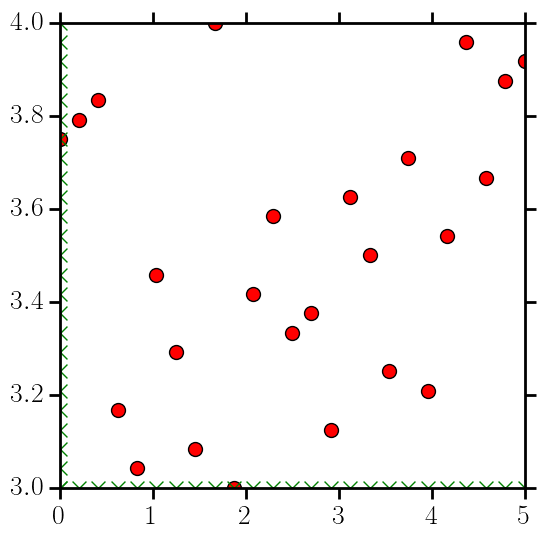

In [13]:
fig, axes = plt.subplots(figsize=(6, 6))
axes.scatter(points[:, 0], points[:, 1], marker='o', s=100, lw=1, c='r')

axes.scatter(points[:, 0], 3.0+0.0*points[:, 1], marker='x', s=100, lw=1, c='g')
axes.scatter(0.0*points[:, 0], points[:, 1], marker='x', s=100, lw=1, c='g')

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])

In [14]:
def latin_hypercube(Ndata, limits):
    """
    """
    Nparams = len(limits)
    
    # Find indices of grid points
    point_ind_list = []
    allowed_indices = np.array([[n for n in range(Ndata)] for i in range(Nparams)])
    for n in range(Ndata):
        js = np.random.randint(Ndata-n, size=Nparams)
        point_ind = [allowed_indices[i, js[i]] for i in range(Nparams)]
        point_ind_list.append(point_ind)
        allowed_indices = np.array([np.delete(allowed_indices[i], js[i]) for i in range(Nparams)])
    
    point_ind_array = np.array(point_ind_list)
    
    # Get grid points
    grids = []
    for i in range(Nparams):
        grids.append(np.linspace(limits[i, 0], limits[i, 1], Ndata))
    
    grids_array = np.array(grids)
    
    # Get chosen points on the grid
    points = np.array([[grids_array[i, point_ind_array[n, i]] for i in range(Nparams)] for n in range(Ndata)])
    
    return points

(3.0, 4.0)

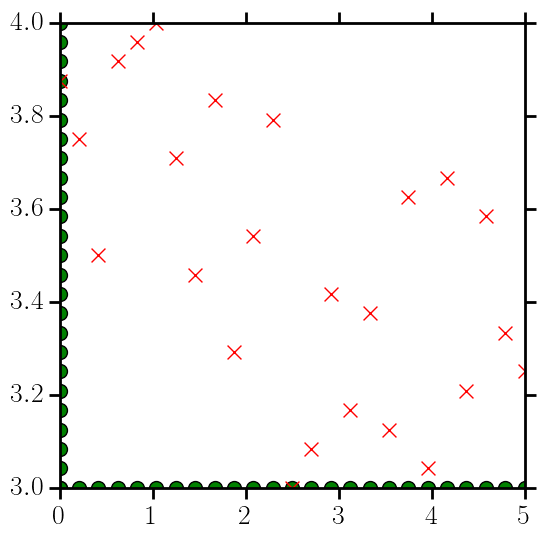

In [16]:
Ndata = 25
limits = np.array([[0.0, 5.0], [3.0, 4.0], [5.2, 7.5]])
points = latin_hypercube(Ndata, limits)

fig, axes = plt.subplots(figsize=(6, 6))

axes.scatter(points[:, 0], 3.0+0.0*points[:, 1], marker='o', s=100, lw=1, c='g')
axes.scatter(0.0*points[:, 0], points[:, 1], marker='o', s=100, lw=1, c='g')

axes.scatter(points[:, 0], points[:, 1], marker='x', s=100, lw=1, c='r')

axes.set_xlim(limits[0])
axes.set_ylim(limits[1])

In [192]:
# Generate data
def func(x, y):
    return 0.1*x*np.sin(x) + 0.02*y**2

Ndata = 50
limits = np.array([[-10.0, 10.0], [-10.0, 10.0]])
points = latin_hypercube(Ndata, limits)
x = points[:, 0]
y = points[:, 1]
params = np.array([x, y]).T
z = func(params[:, 0], params[:, 1])

# Construct Gaussian process
sigma_f = 9.93907466e+00
sigma_n = 1.00909984e-03
ls = np.array([3.71295033e+00, 2.69120938e+01])
gp = GaussianProcess(params, z, covnd, sigma_f, sigma_n, ls)

# Evaluate exact model on grid
xgrid = np.arange(-10, 10, 0.5)
ygrid = np.arange(-10, 10, 0.5)
zgrid = np.array([[func(xp, yp) for yp in ygrid] for xp in xgrid])

# Evaluate Gaussian process on grid
zgpgrid = np.array([[gp.evaluate(np.array([xp, yp]))[0] for yp in ygrid] for xp in xgrid])
zgpsiggrid = np.array([[gp.evaluate(np.array([xp, yp]))[1] for yp in ygrid] for xp in xgrid])

/Library/Python/2.7/site-packages/ipykernel/__main__.py:28: RuntimeWarning: invalid value encountered in sqrt


/Library/Python/2.7/site-packages/ipykernel/__main__.py:21: RuntimeWarning: divide by zero encountered in divide


(-10, 10)

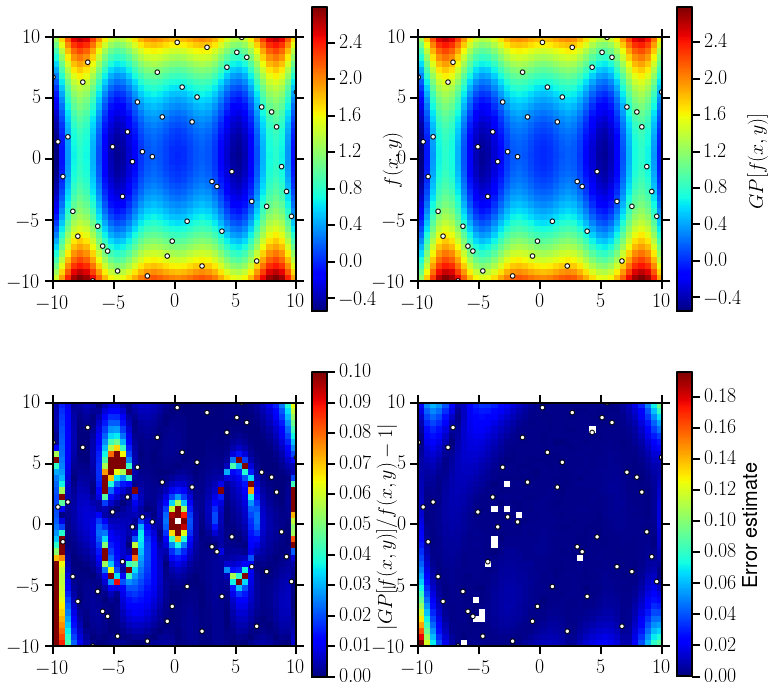

In [193]:
fig, ax = plt.subplots(2, 2, figsize=(12, 12))
axes = ax[0, 0]
extent = [-10, 10, -10, 10]
#im = axes.imshow(zgrid.T, cmap=plt.get_cmap('hot'), interpolation='bilinear', origin='lower')
im = axes.imshow(zgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$f(x, y)$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[0, 1]
im = axes.imshow(zgpgrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$GP[f(x, y)]$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 0]
im = axes.imshow(np.abs(zgpgrid.T/zgrid.T-1.0), interpolation='nearest', origin='lower', extent=extent,
                norm=Normalize(vmin=0, vmax=0.1))
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'$|GP[f(x, y)]/f(x, y)-1|$')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)

axes = ax[1, 1]
im = axes.imshow(zgpsiggrid.T, interpolation='nearest', origin='lower', extent=extent)
cb = plt.colorbar(mappable=im, ax=axes)
cb.set_label(label=r'Error estimate')
axes.scatter(x, y, marker='o', s=20, lw=1, c='w')
axes.set_ylim(-10, 10)
axes.set_xlim(-10, 10)